# Importing Libraries

**LightBGM**
LightBGM is a gradient boosting algorithm i used here as a classifier, it focuses on most informative data points , thus making it effective at picking up rare and critical keywords.

**CatBoost**

CatBoost , on the other hand is used as it is faster and doesnot need extensive pre processing and preserves relationship between different problem types.

In [1]:
!pip install lightgbm
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb

In [ ]:
import joblib

# Importing data

**Getting our dataset from TaskComplexityEval-24** : The dataset provided to as was quite small along with that , it has text written in LATex which made it quite difficult to train model. Also upon printing df.head(),
I got to know that it had certain columns like:
* Title
* Description
* Input_description
* Output_description
* Sample_io
* Problem_class
* Problem_Score


In [ ]:
import pandas as pd

In [ ]:
url="https://raw.githubusercontent.com/AREEG94FAHAD/TaskComplexityEval-24/main/problems_data.jsonl"
df=pd.read_json(url,lines=True)
df.head(5)

,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


# Data Preprocessing

**Data Preprocessing is an important part before training a model. We need to get rid of redundant text from our data , as this may cause noise and along with that reduce accuracy.**

**Thus we remove column of URL , Sample_IO , Title from our dataframe.**
** We keep description , input, output in clean_textual format**

In [ ]:
df.drop(columns=['url','sample_io','title'],axis=1,inplace=True)


In [ ]:
TEXT_COLS = ["description", "input_description", "output_description"]

for col in TEXT_COLS:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col] == "", col] = np.nan
df.isna().sum()

,0
description,81
input_description,120
output_description,131
problem_class,0
problem_score,0


In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3899 entries, 0 to 4111
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         3899 non-null   object 
 1   input_description   3899 non-null   object 
 2   output_description  3899 non-null   object 
 3   problem_class       3899 non-null   object 
 4   problem_score       3899 non-null   float64
dtypes: float64(1), object(4)
memory usage: 182.8+ KB


In [ ]:
def combine_text(row):
    return (
        "PROBLEM: " + str(row['description']) + " " +
        "INPUT_DESCRIPTION: " + str(row['input_description']) + " " +
        "OUTPUT_DESCRIPTION: " + str(row['output_description'])
    )

df['full_text'] = df.apply(combine_text, axis=1)


In [ ]:
df.drop(columns=['description','input_description','output_description'],inplace=True)


** Here we try cleaning certain symbols and LATEX patterns, so that we can get better and understandable Natural language form to train our model**

In [ ]:
LATEX_PATTERNS = [
    r'\$\$.*?\$\$',
    r'\$[^$]*\$',
    r'\\\(.+?\\\)',
    r'\\\[.+?\\\)'
]


def extract_latex(text):
    latex_blocks = []

    def repl(match):
        latex_blocks.append(match.group())
        return f" <LATEX_{len(latex_blocks)-1}> "

    for pattern in LATEX_PATTERNS:
        text = re.sub(pattern, repl, text)

    return text, latex_blocks



def clean_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()



def normalize_fractions(expr):
    pattern = r'\\frac\{([^{}]+)\}\{([^{}]+)\}'
    while re.search(pattern, expr):
        expr = re.sub(pattern, r'(\1)/(\2)', expr)
    return expr


LATEX_MAP = {
    r'\\leq': '<=',
    r'\\le': '<',
    r'\\ge': '>',
    r'\\geq': '>=',
    r'\\neq': '!=',
    r'\\times': '*',
    r'\\cdot': '*',
    r'\\dots': '...',
    r'\\ldots': '...',
    r'\\cdots': '...',
    r'\\\{': '{',
    r'\\\}': '}',
    r'\\,\s*': ''
}



def normalize_latex(expr):
    expr = expr.strip()
    if expr.startswith("$$") and expr.endswith("$$"):
        expr = expr[2:-2]
    elif expr.startswith("$") and expr.endswith("$"):
        expr = expr[1:-1]
    elif expr.startswith("\\(") and expr.endswith("\\)"):
        expr = expr[2:-2]
    elif expr.startswith("\\[") and expr.endswith("\\]"):
        expr = expr[2:-2]

    expr = normalize_fractions(expr)

    for k, v in LATEX_MAP.items():
        expr = re.sub(k, v, expr)

    return expr.strip()



def reinsert(text, latex_blocks, normalize=False):
    for i, block in enumerate(latex_blocks):
        if normalize:
            block = normalize_latex(block)
        text = text.replace(f"<LATEX_{i}>", block)
    return text



def preprocess(text):
    protected_text, latex_blocks = extract_latex(text)
    cleaned = clean_text(protected_text)
    semantic_version = reinsert(cleaned, latex_blocks, normalize=True)
    return semantic_version

df["clean_text"] = df["full_text"].apply(preprocess)
df.drop("full_text",axis=1,inplace=True)

In [ ]:
df.head()

,problem_class,problem_score,clean_text
0,hard,9.7,PROBLEM: Unununium (Uuu) was the name of the c...
1,hard,9.7,PROBLEM: A number of eccentrics from central N...
3,hard,9.6,PROBLEM: Žofka is bending a copper wire. She s...
4,hard,9.6,PROBLEM: Your dog Spot is let loose in the par...
7,hard,9.5,"PROBLEM: Three rival gangs of bandits, the Mar..."


**Finding the Count of class in our dataset is bit important as it tells that our dataset is biased / imbalanced , hence we can try few methods of oversampling to balance our dataset and train our models better**

**As we can see that our model is biased towards Hard more becuase most of the problem score are hard tagged**

problem_class
hard      1845
medium    1327
easy       727
Name: count, dtype: int64


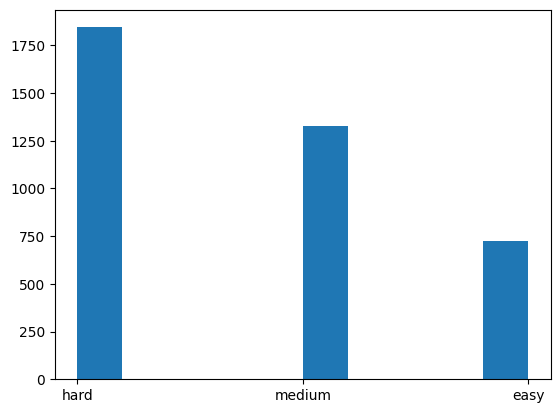

In [ ]:
print(df["problem_class"].value_counts())
plt.hist(df['problem_class'])
plt.show()

count    3899.000000
mean        5.113516
std         2.170811
min         1.100000
25%         3.300000
50%         5.200000
75%         6.900000
max         9.700000
Name: problem_score, dtype: float64


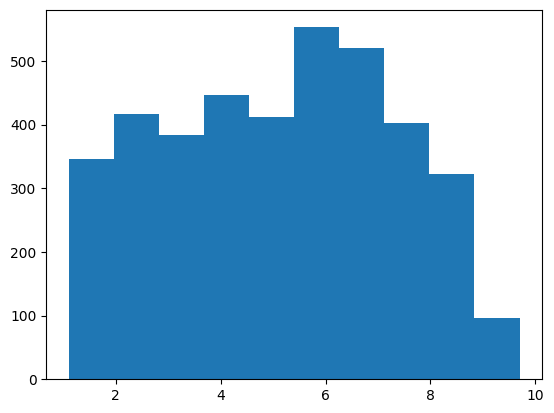

In [ ]:
print(df["problem_score"].describe())
plt.hist(df['problem_score'])
plt.show()

In [ ]:
df.groupby("problem_class")["problem_score"].mean()


,problem_score
problem_class,
easy,1.977442
hard,7.061734
medium,4.122909


# Feature Engineering and Feature Extraction

**One of the most important part before training a model is feature enginnering**

I tried extracting different metrics as features like:
* Complexity Keywords
* Mathematical Intensity
* Structural (Word count, text length, avg word length)
* etc

I Also used TF - IDF (Term Frequency-Inverse Document Frequency) method to assign weights to words that are unique to specific difficulty levels, thus help model differentiate between easy and hard algorithmic description.


## Text Embedding

In [ ]:
model=SentenceTransformer("all-MiniLM-L6-v2")
X_embed = model.encode(
    df["clean_text"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

## New features

In [ ]:
df['text_length']=df['clean_text'].apply(len)

In [ ]:
df.groupby("problem_class")["text_length"].mean()

,text_length
problem_class,
easy,1264.189821
hard,1673.830894
medium,1553.358704


In [ ]:
def math_symbol_count(text):
    return sum(text.count(c) for c in "<>=^*/+-")

df['math_symbol_count']=df['clean_text'].apply(math_symbol_count)

In [ ]:
df.groupby("problem_class")["math_symbol_count"].mean()

,math_symbol_count
problem_class,
easy,7.162311
hard,10.540921
medium,9.756594


In [ ]:
def num_count(text):
    return len(re.findall(r'\d+', text))
df['num_count']=df['clean_text'].apply(num_count)

In [ ]:
df.groupby("problem_class")["num_count"].mean()

,num_count
problem_class,
easy,8.552957
hard,11.406504
medium,11.296910


In [ ]:
POWER_PATTERNS = [
    r'\b\w+\s*\^\s*\w+\b',
    r'\b\w+\s*\^\{\s*\w+\s*\}',
]

power_regex = re.compile("|".join(POWER_PATTERNS))

def has_power_notation(text):
    if not isinstance(text, str):
        return 0
    return int(bool(power_regex.search(text)))

df['has_power_notation']=df['clean_text'].apply(has_power_notation)

In [ ]:
df.groupby("problem_class")["has_power_notation"].mean()

,has_power_notation
problem_class,
easy,0.178817
hard,0.332249
medium,0.326300


In [ ]:
df.head()

,problem_class,problem_score,clean_text,text_length,math_symbol_count,num_count,has_power_notation
0,hard,9.7,PROBLEM: Unununium (Uuu) was the name of the c...,1602,7,6,0
1,hard,9.7,PROBLEM: A number of eccentrics from central N...,1334,5,9,0
3,hard,9.6,PROBLEM: Žofka is bending a copper wire. She s...,1303,4,4,0
4,hard,9.6,PROBLEM: Your dog Spot is let loose in the par...,2121,4,6,0
7,hard,9.5,"PROBLEM: Three rival gangs of bandits, the Mar...",2685,22,12,1


# Data Preparation

In [ ]:
feature_cols = ['has_power_notation','num_count','math_symbol_count','text_length']

df_features = df[feature_cols].values

X = np.hstack([X_embed, df_features])


In [ ]:
list(set(df["problem_class"].values))

['easy', 'hard', 'medium']

In [ ]:
ordinal_order = ['easy', 'medium', 'hard']

ordinal_mapping = {label: idx for idx, label in enumerate(ordinal_order)}

df["problem_class_encoded"] = df["problem_class"].map(ordinal_mapping)
y_class = df["problem_class_encoded"]
y_score = df["problem_score"].values

In [ ]:
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42, stratify=y_class
)


In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Classification



## Logistic Regression

In [ ]:
print("Training LR...\n")

Logistic_Regression_model = LogisticRegression(
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1
)

Logistic_Regression_model.fit(X_train, y_class_train)

y_pred = Logistic_Regression_model.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print(f"Logistic_Regression Accuracy: {acc:.4f}\n")
f1_macro = f1_score(y_class_test, y_pred, average="macro")
print(f"Logistic_Regression F1 : {f1_macro:.4f}\n")

cm = confusion_matrix(y_class_test, y_pred)

cm_df = pd.DataFrame(cm)

print("Confusion Matrix:")
print(cm_df)



Training LR...

Logistic_Regression Accuracy: 0.4513

Logistic_Regression F1 : 0.4429

Confusion Matrix:
    0    1    2
0  87   40   18
1  78   91   97
2  84  111  174


In [ ]:
train_class_pred = Logistic_Regression_model.predict(X_train)
acc = accuracy_score(train_class_pred, y_class_train)
print(f"Logistic Regression Train Accuracy: {acc:.4f}\n")

Logistic Regression Train Accuracy: 0.5681



FOR classification various simple models like:
* RBF SVM
* Polynomial SVM
* LightBGM
* CatBoost

were used and upon getting classification reseults i found LightBoost to be the best , even though SVMs tried catching non linear boundaries and ineqaulities though context and classifching into easy mmedium andhard with such less feature is difficult task for them.

LightBgm , ontherhand is a leaf-wise tree growth thus,allowing it reduce loss and more effectivelly classify problems.It also runs dast and handles sparse data from TF - IDF features to great extent.


## RBF SVM Classifier

In [ ]:
print("Training SVM...\n")

svm_model = SVC(kernel="rbf", class_weight="balanced", random_state=42)
svm_model.fit(X_train, y_class_train)

y_pred = svm_model.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print(f"SVM Accuracy: {acc:.4f}\n")
f1_macro = f1_score(y_class_test, y_pred, average="macro")
print(f"SVM F1 : {f1_macro:.4f}\n")

cm = confusion_matrix(y_class_test, y_pred)

cm_df = pd.DataFrame(cm)

print("Confusion Matrix:")
print(cm_df)



Training SVM...

SVM Accuracy: 0.4115

SVM F1 : 0.3619

Confusion Matrix:
     0   1    2
0   96  13   36
1  121  25  120
2  136  33  200


In [ ]:
train_class_pred = svm_model.predict(X_train)

In [ ]:
acc = accuracy_score(train_class_pred, y_class_train)
print(f"SVM Train Accuracy: {acc:.4f}\n")

SVM Train Accuracy: 0.3976



## Polynomial SVM Classifier

In [ ]:
print("Training SVM...\n")

poly_svm_model = SVC(kernel="poly", class_weight="balanced", random_state=42)
poly_svm_model.fit(X_train, y_class_train)

y_pred = poly_svm_model.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print(f"SVM Accuracy: {acc:.4f}\n")
f1_macro = f1_score(y_class_test, y_pred, average="macro")
print(f"SVM F1 : {f1_macro:.4f}\n")

cm = confusion_matrix(y_class_test, y_pred)

cm_df = pd.DataFrame(cm)

print("Confusion Matrix:")
print(cm_df)



Training SVM...

SVM Accuracy: 0.2590

SVM F1 : 0.2293

Confusion Matrix:
     0   1   2
0  136   9   0
1  211  45  10
2  269  79  21


In [ ]:
train_class_pred = poly_svm_model.predict(X_train)

In [ ]:
acc = accuracy_score(train_class_pred, y_class_train)
print(f"SVM Train Accuracy: {acc:.4f}\n")

SVM Train Accuracy: 0.2501



## LightGBM

In [ ]:

lgb_clf = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=3,
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=10,
    min_data_in_leaf=50,
    lambda_l1=1.0,
    lambda_l2=5.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)



lgb_clf.fit(X_train, y_class_train)

y_pred = lgb_clf.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print(f"LightGBM Accuracy: {acc:.4f}\n")
f1_macro = f1_score(y_class_test, y_pred, average="macro")
print(f"LightGBM F1 : {f1_macro:.4f}\n")

cm = confusion_matrix(y_class_test, y_pred)

cm_df = pd.DataFrame(cm)

print("Confusion Matrix:")
print(cm_df)



LightGBM Accuracy: 0.5077

LightGBM F1 : 0.4635

Confusion Matrix:
    0   1    2
0  59  29   57
1  16  59  191
2  20  71  278


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
train_class_pred = lgb_clf.predict(X_train)
acc = accuracy_score(train_class_pred, y_class_train)
print(f"LightGBM Train Accuracy: {acc:.4f}\n")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Train Accuracy: 0.9250



**Upon using LightBGM , i found train Accuracy to be 90%+ which is clearly the sign of overfitting thus , i needed a better model to ensemble and actually learn and not mugg up . Thus i used CaTBoost which reduces overfitting on small sample set and handles categorical pattern better.**

## CatBoost Classifier

In [ ]:

cat_clf = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    random_seed=42,
    verbose=50,
)

cat_clf.fit(
    X_train, y_class_train
)

y_pred = cat_clf.predict(X_test)

acc = accuracy_score(y_class_test, y_pred)
print(f"CatBoost Accuracy: {acc:.4f}\n")
f1_macro = f1_score(y_class_test, y_pred, average="macro")
print(f"CatBoost F1 : {f1_macro:.4f}\n")

cm = confusion_matrix(y_class_test, y_pred)

cm_df = pd.DataFrame(cm)

print("Confusion Matrix:")
print(cm_df)


0:	learn: 1.0906886	total: 382ms	remaining: 1m 54s
50:	learn: 0.9237377	total: 13.2s	remaining: 1m 4s
100:	learn: 0.8432941	total: 26s	remaining: 51.3s
150:	learn: 0.7808588	total: 38.8s	remaining: 38.3s
200:	learn: 0.7209196	total: 51.6s	remaining: 25.4s
250:	learn: 0.6615919	total: 1m 4s	remaining: 12.6s
299:	learn: 0.6081631	total: 1m 17s	remaining: 0us
CatBoost Accuracy: 0.5013

CatBoost F1 : 0.4205

Confusion Matrix:
    0   1    2
0  44  23   78
1  16  45  205
2  19  48  302


In [ ]:
train_class_pred = cat_clf.predict(X_train)
acc = accuracy_score(train_class_pred, y_class_train)
print(f"CatBoost Train Accuracy: {acc:.4f}\n")

CatBoost Train Accuracy: 0.9051



# Regression

Using Ridge Regressor as a linear Baseline model with alpha 1.0 helps us penalise and prevent model from becoming too sensitive to any single word in TF-IDF set.



## Ridge Regressor

In [ ]:


ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_score_train)
y_pred = ridge.predict(X_test)


mae = mean_absolute_error(y_score_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred))

print("Ridge Regressor")
print("MAE :", mae)
print("RMSE:", rmse)


Ridge Regressor
MAE : 1.6618534929058424
RMSE: 2.0117902225290565


In [ ]:
train_pred = ridge.predict(X_train)
print("Train MAE:", mean_absolute_error(y_score_train, train_pred))
print("Test MAE :", mean_absolute_error(y_score_test, y_pred))


Train MAE: 1.5767966004209282
Test MAE : 1.6618534929058424


In [ ]:
df.groupby("problem_class")["problem_score"].std()


,problem_score
problem_class,
easy,0.427547
hard,1.037141
medium,0.775659


**Displaying scatterplot of Predicted score and True Score of Problem score**  

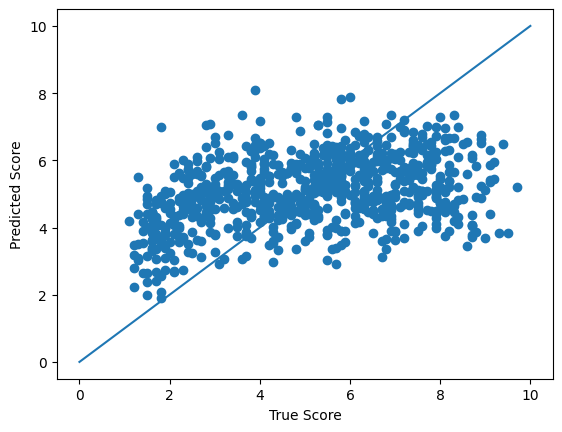

In [ ]:

plt.scatter(y_score_test, y_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


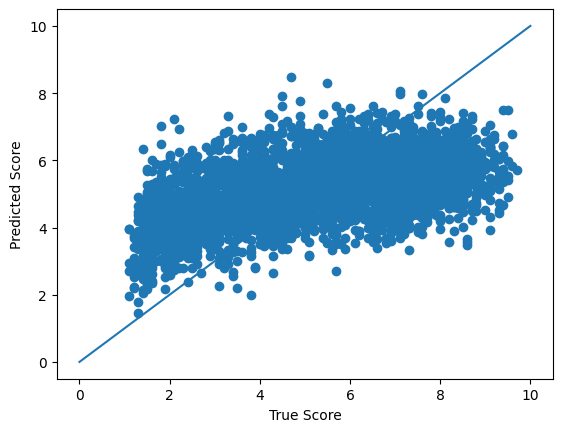

In [ ]:

plt.scatter(y_score_train, train_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


## Gradient Boosting Regressor

It was used to capture the non-linear "residuals" of the data. It builds trees sequentially, where each tree aims to minimize the error of the previous one, which is perfect for fine-tuning the difficulty score based on complex problem descriptions.

In [ ]:


gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3)
gbr.fit(X_train, y_score_train)
y_pred= gbr.predict(X_test)

mae = mean_absolute_error(y_score_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred))

print("Gradient Boost Regressor")
print("MAE :", mae)
print("RMSE:", rmse)


Gradient Boost Regressor
MAE : 1.6834687847923486
RMSE: 2.003517653086698


In [ ]:
train_pred = gbr.predict(X_train)
print("Train MAE:", mean_absolute_error(y_score_train, train_pred))
print("Test MAE :", mean_absolute_error(y_score_test, y_pred))


Train MAE: 1.2149879282552123
Test MAE : 1.6834687847923486


In [ ]:
df.groupby("problem_class")["problem_score"].std()


,problem_score
problem_class,
easy,0.427547
hard,1.037141
medium,0.775659


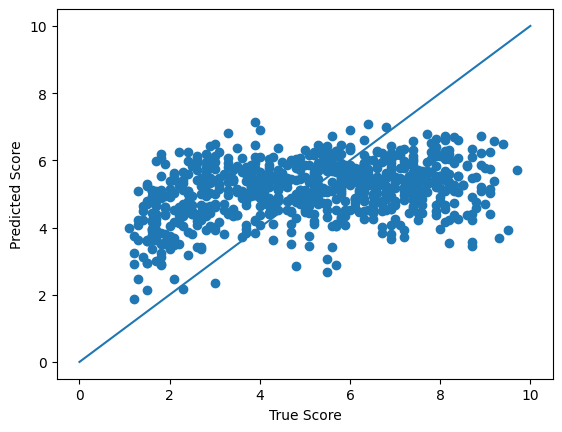

In [ ]:

plt.scatter(y_score_test, y_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


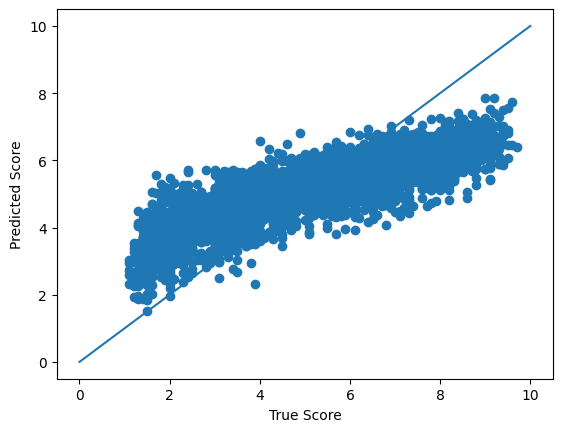

In [ ]:

plt.scatter(y_score_train, train_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


## LightGBM regressor

In [ ]:
lgb_reg = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=300,
    learning_rate=0.03,
    num_leaves=15,
    max_depth=6,
    min_data_in_leaf=50,
    lambda_l1=1.0,
    lambda_l2=5.0,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    verbose=-1
)


lgb_reg.fit(X_train, y_score_train)
y_pred = lgb_reg.predict(X_test)

mae = mean_absolute_error(y_score_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_pred))

print("LightGBM Regressor")
print("MAE :", mae)
print("RMSE:", rmse)


LightGBM Regressor
MAE : 1.6761234091088932
RMSE: 1.999837313710391


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
train_pred = lgb_reg.predict(X_train)
print("Train MAE:", mean_absolute_error(y_score_train, train_pred))
print("Test MAE :", mean_absolute_error(y_score_test, y_pred))


Train MAE: 1.0517661547388208
Test MAE : 1.6761234091088932


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
df.groupby("problem_class")["problem_score"].std()


,problem_score
problem_class,
easy,0.427547
hard,1.037141
medium,0.775659


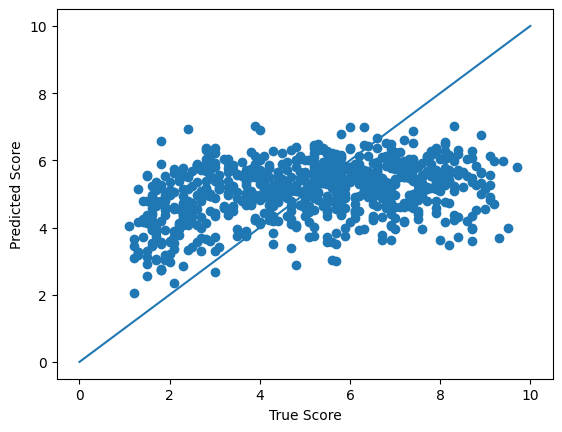

In [ ]:

plt.scatter(y_score_test, y_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


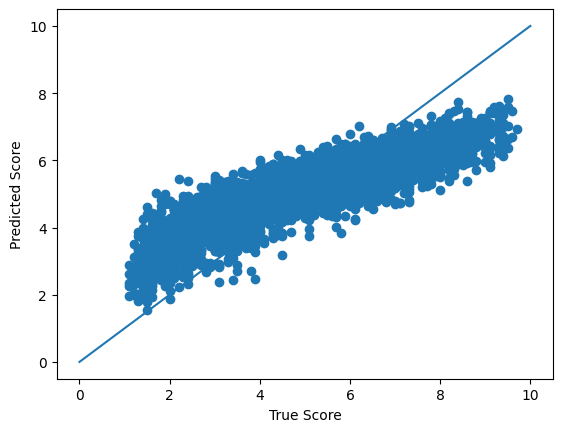

In [ ]:

plt.scatter(y_score_train, train_pred)
plt.plot([0,10],[0,10])
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


# Saving the Model

In [ ]:

best_model_clf = lgb_clf  # Or your SVM/LogisticRegression variable
best_model_reg = gbr  # Or your SVM/LogisticRegression variable

joblib.dump(best_model_clf, 'clf_model.pkl')
joblib.dump(best_model_reg, 'reg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
print(df.columns.tolist())

['problem_class', 'problem_score', 'clean_text', 'text_length', 'math_symbol_count', 'num_count', 'has_power_notation', 'problem_class_encoded']


In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler
from google.colab import files

def manual_extract(text):
    if not isinstance(text, str): text = ""
    text_lower = text.lower()

    latex_count = len(re.findall(r'\$[^\$]+\$|\\\w+', text))
    numbers = re.findall(r'\d+', text)
    nums = [int(n) for n in numbers if len(n) < 10]

    math_weight = 0
    constraints = re.findall(r'(?:10\^|10\*\*|1e)(\d+)|(\d{4,12})', text)
    for pwr, val in constraints:
        if pwr and int(pwr) >= 5: math_weight = max(math_weight, 2.0)
        if val and int(val) > 1e7: math_weight = max(math_weight, 3.0)

    keywords = ['dynamic', 'graph', 'tree', 'greedy', 'sort', 'prime', 'segment', 'flow', 'dp', 'bitmask']
    kw_count = sum(text_lower.count(k) for k in keywords)

    return np.array([
        len(text), len(text.split()), len(text)/max(len(text.split()), 1),
        latex_count, text.count('$'),
        len(nums), max(nums, default=0), 1 if nums and max(nums) > 1e6 else 0,
        kw_count, text.count('.'), text.count('?'),
        1 if 'input' in text_lower else 0, 1 if 'constraint' in text_lower else 0,
        1 if 'example' in text_lower else 0, 1 if 'output' in text_lower else 0,
        math_weight, 1.0
    ])


X_manual = np.array([manual_extract(str(t)) for t in df['clean_text']])

scaler_17 = StandardScaler()
X_scaled_17 = scaler_17.fit_transform(X_manual)

best_model_clf.fit(X_scaled_17, df['problem_class_encoded'])
best_model_reg.fit(X_scaled_17, df['problem_score'])

model_bundle = {
    'clf': best_model_clf,
    'reg': best_model_reg,
    'scaler': scaler_17,
    'tfidf': None
}

with open('improved_model.pkl', 'wb') as f:
    pickle.dump(model_bundle, f)

files.download('improved_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! Upload this 'improved_model.pkl' to Hugging Face.
